In [1]:
import os, sys, time, pickle, glob
from pathlib import Path

# numpy to SITK conversion
import torch
import numpy     as np
import SimpleITK as sitk

# meshio for 3DSlicer segm obj
import meshio


# segmentation
from scipy.spatial   import Delaunay
    

# hardware stats
import GPUtil as GPU

# plot
from helpers.viz import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.viz import *


# Segm Obj -> SITK

# 1. Get affine matrix in SITK
# https://niftynet.readthedocs.io/en/v0.2.2/_modules/niftynet/io/simple_itk_as_nibabel.html
def make_affine(simpleITKImage, ras_adj):
    # get affine transform in LPS
    c = [simpleITKImage.TransformIndexToPhysicalPoint(p)
         for p in ((1, 0, 0),
                   (0, 1, 0),
                   (0, 0, 1),
                   (0, 0, 0))]
    c = np.array(c)
    affine = np.concatenate([
        np.concatenate([c[0:3] - c[3:], c[3:]], axis=0),
        [[0.], [0.], [0.], [1.]]
    ], axis=1)
    affine = np.transpose(affine)
    # convert to RAS to match nibabel
    if ras_adj:
        affine = np.matmul(np.diag([-1., -1., 1., 1.]), affine)
    return affine

    
# sitk obj and np array have different index conventions
# deep copy
def sitk2np(obj): return np.swapaxes(sitk.GetArrayFromImage(obj), 0, 2)
def np2sitk(arr): return sitk.GetImageFromArray(np.swapaxes(arr, 0, 2))

def torch2sitk(t): return sitk.GetImageFromArray(torch.transpose(t, 0, 2))
def sitk2torch(o): return torch.transpose(torch.tensor(sitk.GetArrayFromImage(o)), 0, 2)



# Viz data

Souces:

- https://colab.research.google.com/github/hardik0/AI-for-Medicine-Specialization/blob/master/AI-for-Medical-Diagnosis/Week-3/Explore_MRI_data.ipynb#scrollTo=nLgMNEFolcHr

In [2]:
# set root directory of data
DATA = "/home/gologors/data/"


In [3]:
# utilities
import os, sys, time, json

# graphing
from matplotlib import gridspec, colors

import matplotlib.pyplot as plt
import seaborn as sns

# data
import numpy as np
import pandas as pd

# nii
import SimpleITK as sitk

# interactive
from ipywidgets import interact, interactive, IntSlider, ToggleButtons, fixed

# helpers

# add root to filepath (=os.path.join)
def getfp(fn, root=DATA): return f"{root}/{fn}"

# sitk obj and np array have different index conventions
# deep copy
def sitk2np(obj): return np.swapaxes(sitk.GetArrayFromImage(obj), 0, 2)
def np2sitk(arr): return sitk.GetImageFromArray(np.swapaxes(arr, 0, 2))

# round all floats in a tuple to 3 decimal places
def round_tuple(t, d=2): return tuple(round(x,d) for x in t)

def orient_test(image):
    orient = sitk.DICOMOrientImageFilter()
    orient.DebugOn()
    print(round_tuple(image.GetDirection(), d=2))
    print(orient.GetOrientationFromDirectionCosines(image.GetDirection()))

# print sitk info
def print_sitk_info(image):   
    orient = sitk.DICOMOrientImageFilter()

    print("Size: ", image.GetSize())
    print("Origin: ", image.GetOrigin())
    print("Spacing: ", image.GetSpacing())
    print("Direction: ", round_tuple(image.GetDirection(), d=2))
    print("Orientation: ", orient.GetOrientationFromDirectionCosines(image.GetDirection()))
    print(f"Pixel type: {image.GetPixelIDValue()} = {image.GetPixelIDTypeAsString()}")

# Sequences to align

We align the following: Cor T1, Cor T2, +Cor T1 (i.e. with contrast).

1. Get .niis associated w/ seq
2. Convert .nii to sitk obj
    - re-orient to LAS
    - crop to foreground via threshold
3. Resample all sitk objs to same reference frame
4. Elastix rigid align (Euler transform) via reg.py

In [4]:
def fp2sitk(fp):
    """ Orient to LAS & Crop to Foreground """
    im_obj = sitk.ReadImage(fp)
    return threshold_based_crop(sitk.DICOMOrient(im_obj, "LAS"))
    
# Crop https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb
def threshold_based_crop(image):
    '''
    Use Otsu's threshold estimator to separate background and foreground. In medical imaging the background is
    usually air. Then crop the image using the foreground's axis aligned bounding box.
    Args:
        image (SimpleITK image): An image where the anatomy and background intensities form a bi-modal distribution
                                 (the assumption underlying Otsu's method.)
    Return:
        Cropped image based on foreground's axis aligned bounding box.  
    '''
    # Set pixels that are in [min_intensity,otsu_threshold] to inside_value, values above otsu_threshold are
    # set to outside_value. The anatomy has higher intensity values than the background, so it is outside.
    inside_value = 0
    outside_value = 255
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
    label_shape_filter.Execute( sitk.OtsuThreshold(image, inside_value, outside_value) )
    bounding_box = label_shape_filter.GetBoundingBox(outside_value)
    # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
    return sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)])

# get standard reference domain

# src: https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb
def get_reference_frame(img_data):
    #img_data = [(o.GetSize(), o.GetSpacing()) for o in objs]

    dimension = 3 # 3D MRs
    pixel_id = 8 # 2 = 16-bit signed integer

    # Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
    reference_physical_size = np.zeros(dimension)

    for img_sz, img_spc in img_data:
        reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx else mx \
                                      for sz, spc, mx in zip(img_sz, img_spc, reference_physical_size)]

    # Create the reference image with a zero origin, identity direction cosine matrix and dimension     
    reference_origin = np.zeros(dimension)
    reference_direction = np.identity(dimension).flatten()

    # Non-Isotropic pixels
    reference_spacing = new_spacing
    reference_size = [int(phys_sz/(spc) + 1) for phys_sz,spc in zip(reference_physical_size, reference_spacing)]

    # Set reference image attributes
    reference_image = sitk.Image(reference_size, pixel_id)
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)

    reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))
    return reference_image, (reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center)

def get_reference_image(reference_frame):
    reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center = reference_frame
    reference_image = sitk.Image(reference_size, pixel_id)
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)
    return reference_image, reference_center

def resample2reference(img, reference_image, reference_center, \
                       interpolator = sitk.sitkLinear, default_intensity_value = 0.0, dimension=3):
    
    # Define translation transform mapping origins from reference_image to the current img
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_image.GetOrigin())
    
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    
    centered_transform = sitk.CompositeTransform([centering_transform])
    
#     centered_transform = sitk.Transform(transform)
#     centered_transform.AddTransform(centering_transform)
    
    return sitk.Resample(img, reference_image, centered_transform, interpolator, default_intensity_value, img.GetPixelID())

In [14]:
import pickle
from pathlib import Path

root = "/home/gologors/data/"

with open(root + 'pitmri/' + 'all_loni_filenames.pkl', 'rb') as f: 
    loni_filenames = pickle.load(f)
    
with open(root + 'pitmri/' + 'all_filenames.pkl', 'rb') as f: 
    pit_filenames = pickle.load(f)

In [9]:
reader = sitk.ImageFileReader()

reader.SetFileName(loni_filenames[0][0])
reader.ReadImageInformation()

for k in reader.GetMetaDataKeys():
    v = reader.GetMetaData(k)
    print(f"({k}) = = \"{v}\"")

print(f"Image Size: {reader.GetSize()}")
print(f"Image PixelType: {sitk.GetPixelIDValueAsString(reader.GetPixelID())}")

print(reader.GetSize(), reader.GetSpacing())
#  img_data = [(o.GetSize(), o.GetSpacing()) for o in objs]



(ITK_FileNotes) = = "FSL4.0"
(aux_file) = = ""
(bitpix) = = "16"
(cal_max) = = "0"
(cal_min) = = "0"
(datatype) = = "4"
(descrip) = = "FSL4.0"
(dim[0]) = = "3"
(dim[1]) = = "208"
(dim[2]) = = "256"
(dim[3]) = = "176"
(dim[4]) = = "1"
(dim[5]) = = "1"
(dim[6]) = = "1"
(dim[7]) = = "1"
(dim_info) = = "0"
(intent_code) = = "0"
(intent_name) = = ""
(intent_p1) = = "0"
(intent_p2) = = "0"
(intent_p3) = = "0"
(nifti_type) = = "1"
(pixdim[0]) = = "0"
(pixdim[1]) = = "1"
(pixdim[2]) = = "1"
(pixdim[3]) = = "1"
(pixdim[4]) = = "2.5"
(pixdim[5]) = = "0"
(pixdim[6]) = = "0"
(pixdim[7]) = = "0"
(qform_code) = = "1"
(qform_code_name) = = "NIFTI_XFORM_SCANNER_ANAT"
(qoffset_x) = = "108.471"
(qoffset_y) = = "-127.726"
(qoffset_z) = = "-107.837"
(quatern_b) = = "-0"
(quatern_c) = = "-0.999994"
(quatern_d) = = "-0"
(scl_inter) = = "0"
(scl_slope) = = "1"
(sform_code) = = "1"
(sform_code_name) = = "NIFTI_XFORM_SCANNER_ANAT"
(slice_code) = = "0"
(slice_duration) = = "0"
(slice_end) = = "0"
(slice_start) 

In [10]:
def get_stem_name(fn):
    basename = os.path.basename(fn)
    return basename[:basename.index(".nii")]

In [11]:
def get_im_data(fn):
    reader = sitk.ImageFileReader()

    reader.SetFileName(fn)
    reader.ReadImageInformation()

#     for k in reader.GetMetaDataKeys():
#         v = reader.GetMetaData(k)
#         print(f"({k}) = = \"{v}\"")

#     print(f"Image Size: {reader.GetSize()}")
#     print(f"Image PixelType: {sitk.GetPixelIDValueAsString(reader.GetPixelID())}")

    return (reader.GetSize(), reader.GetSpacing())

In [12]:
# import pickle
# from pathlib import Path

# root = "/home/gologors/data/"

# with open(root + 'pitmri/' + 'all_loni_filenames.pkl', 'rb') as f: 
#     loni_filenames = pickle.load(f)
    
# fps = {get_stem_name(im_fn):im_fn for im_fn, seg_fn in loni_filenames}

# im_data = [get_im_data(im_fn) for im_fn, seg_fn in loni_filenames]

# # resample to same domain
# new_spacing = (0.41015625, 3.0, 0.41015625)
# loni_reference_image, loni_reference_frame = get_reference_frame(im_data)

# # unpack reference frame
# reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center = reference_frame

# # print
# print("Loni Reference Image")
# print_sitk_info(loni_reference_image)

# # for im_fn, seg_fn in pit_filenames:
# #     print(get_stem_name(im_fn))

In [15]:
fps = {get_stem_name(im_fn):im_fn for im_fn, seg_fn in pit_filenames}

im_data = [get_im_data(im_fn) for im_fn, seg_fn in pit_filenames]

# resample to same domain
new_spacing = (0.41015625, 3.0, 0.41015625)
reference_image, reference_frame = get_reference_frame(im_data)

# unpack reference frame
reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center = reference_frame

# print
print("Reference Image")
print_sitk_info(reference_image)

# for im_fn, seg_fn in pit_filenames:
#     print(get_stem_name(im_fn))

Reference Image
Size:  (512, 74, 460)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LPS
Pixel type: 8 = 32-bit float


In [16]:
i = 0

for im_fn, lbl_fn in loni_filenames:
    # Read in fns
    im         = sitk.ReadImage(im_fn, sitk.sitkFloat32)
    lbl_mesh   = meshio.read(lbl_fn)

    # Mesh -> boolean array (Delauney triangulation)
    dims    = im.GetSize()
    aff     = make_affine(im, ras_adj=False)
    idx_pts = np.indices(dims[::-1], dtype=np.uint16).T.reshape(-1,3)[:,[2,1,0]]
    physical_pts = (np.dot(aff[:3,:3], idx_pts.T) + aff[:3,3:4]).T 
    
    lbl_arr = (Delaunay(lbl_mesh.points).find_simplex(physical_pts) >= 0).reshape(dims)

    # Boolean arr -> SITK w/ same 
    lbl = sitk.GetImageFromArray(np.swapaxes(lbl_arr.astype(np.uint8), 0, 2))
    lbl.SetOrigin(im.GetOrigin())
    lbl.SetSpacing(im.GetSpacing())   
    lbl.SetDirection(im.GetDirection())
    
    # Recenter
    im  = resample2reference(im, reference_image, reference_center)
    lbl = resample2reference(lbl, reference_image, reference_center)
    
    # Re-orient to LAS
    im = sitk.DICOMOrient(im, "LAS")
    lbl = sitk.DICOMOrient(lbl, "LAS")
    
    # Save as pytorch tensor
    lbl_pt = sitk2torch(lbl)
    im_pt  = sitk2torch(im)
    
    basename = get_stem_name(im_fn)
    torch.save(im_pt, root + 'pitmri/resampled_loni/im_' + basename + '.pt')
    torch.save(lbl_pt, root + 'pitmri/resampled_loni/lbl_' + basename + '.pt')
    
    # Counter
    print(f"Done {i}")
    i += 1

Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
Done 16
Done 17
Done 18
Done 19
Done 20
Done 21
Done 22
Done 23
Done 24
Done 25
Done 26
Done 27
Done 28
Done 29
Done 30
Done 31
Done 32
Done 33
Done 34
Done 35
Done 36
Done 37
Done 38
Done 39
Done 40
Done 41
Done 42
Done 43
Done 44
Done 45
Done 46
Done 47
Done 48
Done 49
Done 50
Done 51
Done 52
Done 53
Done 54
Done 55
Done 56
Done 57
Done 58
Done 59
Done 60
Done 61
Done 62
Done 63
Done 64
Done 65
Done 66
Done 67
Done 68
Done 69
Done 70
Done 71
Done 72
Done 73
Done 74
Done 75
Done 76
Done 77
Done 78
Done 79
Done 80
Done 81
Done 82
Done 83
Done 84
Done 85
Done 86
Done 87
Done 88
Done 89
Done 90
Done 91
Done 92
Done 93
Done 94
Done 95
Done 96
Done 97
Done 98
Done 99
Done 100
Done 101
Done 102
Done 103
Done 104
Done 105
Done 106
Done 107
Done 108


OSError: [Errno 28] No space left on device

In [12]:
# # fps  = {seq:seq2fp(seq) for seq in seqs}
# objs = {seq:fp2sitk(fp) for seq,fp in fps.items()}

In [27]:
# for seq,obj in objs.items():
#     print("*"*50)
#     print(seq)
#     print_sitk_info(obj)
#     print("*"*50)

**************************************************
COR T1
Size:  (380, 17, 484)
Origin:  (-98.93094815072925, 15.964123981760224, -110.72881635369274)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (0.98, 0.09, 0.15, 0.08, -0.99, 0.06, -0.15, 0.04, 0.99)
Orientation:  LAS
Pixel type: 8 = 32-bit float
**************************************************
**************************************************
COR T2
Size:  (356, 17, 454)
Origin:  (-98.94240546854581, 15.963736497488119, -110.7132399431765)
Spacing:  (0.4375, 3.0, 0.4375)
Direction:  (0.98, 0.09, 0.15, 0.08, -0.99, 0.06, -0.15, 0.04, 0.99)
Orientation:  LAS
Pixel type: 8 = 32-bit float
**************************************************
**************************************************
+COR T1
Size:  (383, 17, 489)
Origin:  (-99.33489810000317, 15.92953018699912, -110.66672080425725)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (0.98, 0.09, 0.15, 0.08, -0.99, 0.06, -0.15, 0.04, 0.99)
Orientation:  LAS
Pixel type: 8 =

In [32]:
# resample to same domain
new_spacing = (0.41015625, 3.0, 0.41015625)
reference_image, reference_frame = get_reference_frame(fps, new_spacing)

# unpack reference frame
reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center = reference_frame

# print
print("Reference Image")
print_sitk_info(reference_image)

Reference Image
Size:  (383, 17, 489)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LPS
Pixel type: 8 = 32-bit float


In [ ]:
Reference Image
Size:  (512, 74, 460)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LPS
Pixel type: 8 = 32-bit float
    
Loni Reference Image
Size:  (632, 90, 652)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LPS
Pixel type: 8 = 32-bit float

In [40]:
# resample to reference
resampled_objs = {seq:resample2reference(o, reference_image, reference_center) for seq,o in objs.items()}

In [41]:
for seq,obj in resampled_objs.items():
    print("*"*50)
    print(seq)
    print_sitk_info(obj)
    print("*"*50)

**************************************************
COR T1
Size:  (383, 17, 489)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LPS
Pixel type: 8 = 32-bit float
**************************************************
**************************************************
COR T2
Size:  (383, 17, 489)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LPS
Pixel type: 8 = 32-bit float
**************************************************
**************************************************
+COR T1
Size:  (383, 17, 489)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (0.41015625, 3.0, 0.41015625)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Orientation:  LPS
Pixel type: 8 = 32-bit float
**************************************************


In [5]:
def get_arr(seq):
    # get filepath to sequence
    seq_idx = series_info.loc[:,5] == seq
    fn      = series_info.loc[seq_idx,1].values[0]
    
    # get files in dir
    all_files = sorted(os.listdir(getfp(fn)))
    niis  = [x for x in all_files if x.endswith(".nii.gz")]
    jsons = [x for x in all_files if x.endswith(".json")] 
    dcms  = [x for x in all_files if x.endswith(".dcm")]
    
    # check if more than one
    if len(niis) != 1:
        print(f"Nii isn't unique! {seq}")
        
    # open .nii files
    im_obj = sitk.ReadImage(getfp(f"{fn}/{niis[0]}"))
    
    # reorient to LAS
    im_obj = sitk.DICOMOrient(im_obj, "LAS")
        
    im_arr = sitk2np(im_obj)
    
    return im_arr

In [6]:
ims = [get_arr(seq) for seq in seqs]

In [7]:
axis = 1
nslices = ims[0].shape[axis]

print(nslices)

17


# Pre-Alignment

In [8]:
def to_binary_im(img, threshold=150):
    # make all pixels < threshold black
    binarized = 1.0 * (img > threshold)
    
    return binarized

def get_binary_cm(col1="white", col2="red"): return colors.ListedColormap([col1, col2])

seq_colors = ["red", "green", "blue"]

(-0.5, 511.5, 511.5, -0.5)

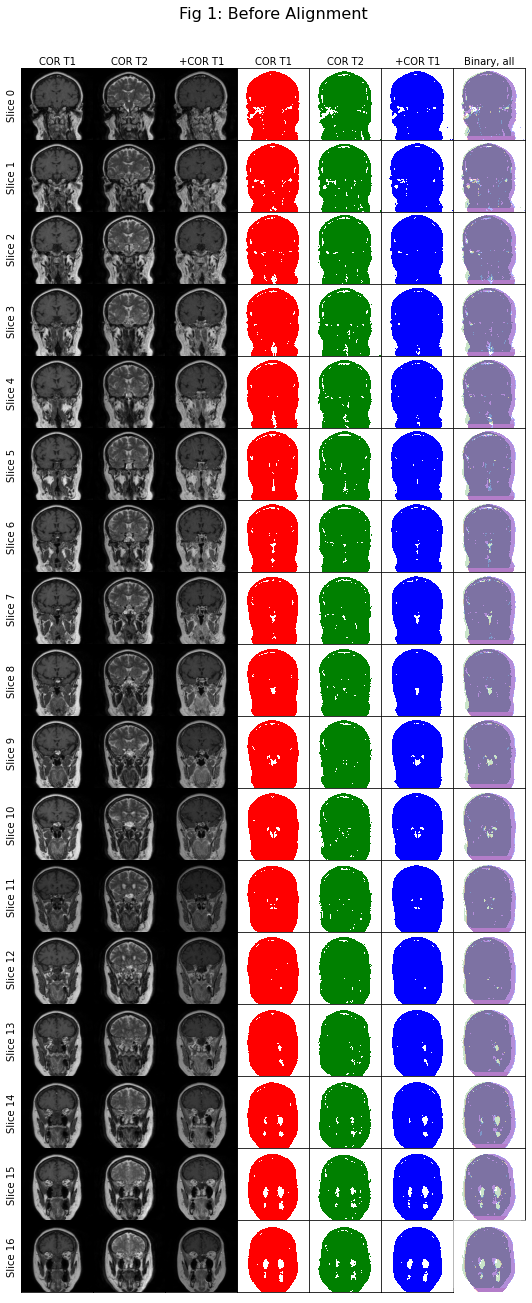

In [23]:
ncols = len(ims) + len(ims) + 1
nrows = nslices

# fig options
fig_mult = 1
options = {
    "wspace": 0.0,
    "hspace": 0.0,
}

fig = plt.figure(figsize=(fig_mult*(ncols+1), fig_mult*(nrows+1))) 
gs  = gridspec.GridSpec(nrows, ncols,
        wspace=options["wspace"], hspace=options["hspace"], 
        top=1.-0.5/(nrows+1), bottom=0.5/(nrows+1), 
        left=0.5/(ncols+1), right=1-0.5/(ncols+1)) 
    
for row_idx, slice_idx in enumerate(range(nslices)):
    for col_idx, im_arr in enumerate(ims):
        im = np.take(im_arr, slice_idx, axis=axis)
        
        # plot original slice
        ax = plt.subplot(gs[row_idx,col_idx])
        ax.imshow(np.rot90(im), cmap=plt.cm.gray)
        
        # plot binary cmaps
        ax_next = plt.subplot(gs[row_idx,col_idx+len(ims)])
        ax_next.imshow(np.rot90(to_binary_im(im)), cmap=get_binary_cm(col2=seq_colors[col_idx]))
        
        # label the columns top of the plot
        if row_idx == 0:
            ax.set_xlabel(f'{seqs[col_idx]}')    
            ax.xaxis.set_label_position('top') 
            
            ax_next.set_xlabel(f'{seqs[col_idx]}')    
            ax_next.xaxis.set_label_position('top') 
        
        if col_idx == 0:
            # label the rows on the left side of the plot
            ax.set_ylabel(f'Slice {row_idx}')    
            ax.yaxis.set_label_position('left') 
            
        # remove tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax_next.set_xticks([])
        ax_next.set_yticks([])
        
# plot last col w/ all binary maps overlaid
for row_idx, slice_idx in enumerate(range(nslices)):
        
        im_slices = [np.take(to_binary_im(im_arr), slice_idx, axis=axis) for im_arr in ims]
        
        # plot next col
        ax = plt.subplot(gs[row_idx,len(ims)+len(ims)])
            
        for im_slice, col in zip(im_slices, seq_colors):
            ax.imshow(np.rot90(im_slice), cmap=get_binary_cm(col2=col), alpha=0.3)
        
            if row_idx == 0:
                ax.set_xlabel(f'Binary, all')    
                ax.xaxis.set_label_position('top') 
            
            # remove tick marks
            ax.set_xticks([])
            ax.set_yticks([])

fig.suptitle('Fig 1: Before Alignment', y=1.01, fontsize=16)
plt.axis('off')

# Post-Alignment

In [24]:
def get_aligned_arr(moving_seq, fixed_seq="COR T1"):
    fn = getfp(f"elastix/{moving_seq}_aligned_to_{fixed_seq}.nii")    
    im_obj = sitk.ReadImage(fn)
    im_arr = sitk2np(im_obj)
    return im_arr


In [25]:
fixed_seq = "COR T1"
moving_seqs= ["COR T2", "+COR T1"]

aligned_ims = {moving_seq: get_aligned_arr(moving_seq) for moving_seq in moving_seqs}

In [26]:
for moving_seq in moving_seqs:
    print(aligned_ims[moving_seq].shape)

(512, 17, 512)
(512, 17, 512)


In [27]:
aligned_moving_seqs = [fixed_seq, *moving_seqs]
aligned_ims = [ims[0]] + [get_aligned_arr(moving_seq) for moving_seq in moving_seqs]

(-0.5, 511.5, 511.5, -0.5)

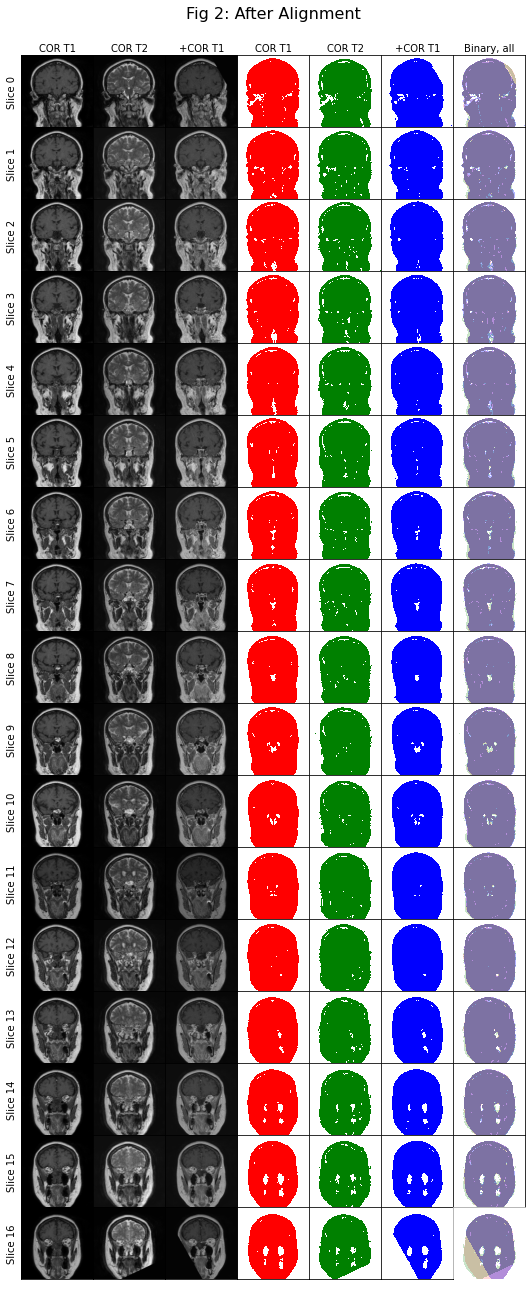

In [28]:
ncols = len(ims) + len(ims) + 1
nrows = nslices

# fig options
fig_mult = 1
options = {
    "wspace": 0.0,
    "hspace": 0.0,
}

fig = plt.figure(figsize=(fig_mult*(ncols+1), fig_mult*(nrows+1))) 
gs  = gridspec.GridSpec(nrows, ncols,
        wspace=options["wspace"], hspace=options["hspace"], 
        top=1.-0.5/(nrows+1), bottom=0.5/(nrows+1), 
        left=0.5/(ncols+1), right=1-0.5/(ncols+1)) 
    
for row_idx, slice_idx in enumerate(range(nslices)):
    for col_idx, im_arr in enumerate(aligned_ims):
        im = np.take(im_arr, slice_idx, axis=axis)
        
        # plot original slice
        ax = plt.subplot(gs[row_idx,col_idx])
        ax.imshow(np.rot90(im), cmap=plt.cm.gray)
        
        # plot binary cmaps
        ax_next = plt.subplot(gs[row_idx,col_idx+len(ims)])
        ax_next.imshow(np.rot90(to_binary_im(im)), cmap=get_binary_cm(col2=seq_colors[col_idx]))
        
        # label the columns top of the plot
        if row_idx == 0:
            ax.set_xlabel(f'{seqs[col_idx]}')    
            ax.xaxis.set_label_position('top') 
            
            ax_next.set_xlabel(f'{seqs[col_idx]}')    
            ax_next.xaxis.set_label_position('top') 
       
        if col_idx == 0:
            # label the rows on the left side of the plot
            ax.set_ylabel(f'Slice {row_idx}')    
            ax.yaxis.set_label_position('left') 
            
        # remove tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax_next.set_xticks([])
        ax_next.set_yticks([])
        
# plot last col w/ all binary maps overlaid
for row_idx, slice_idx in enumerate(range(nslices)):
        
        im_slices = [np.take(to_binary_im(im_arr), slice_idx, axis=axis) for im_arr in aligned_ims]
        
        # plot next col
        ax = plt.subplot(gs[row_idx,len(aligned_ims)+len(aligned_ims)])
            
        for im_slice, col in zip(im_slices, seq_colors):
            ax.imshow(np.rot90(im_slice), cmap=get_binary_cm(col2=col), alpha=0.3)
        
            if row_idx == 0:
                ax.set_xlabel(f'Binary, all')    
                ax.xaxis.set_label_position('top') 
            
            # remove tick marks
            ax.set_xticks([])
            ax.set_yticks([])
            
fig.suptitle('Fig 2: After Alignment', y=1.01, fontsize=16)
plt.axis('off')

In [15]:
moving_seqs

['COR T2', '+COR T1']

In [29]:
# Compare before-and-after

col_names = ["COR T1", "COR T2", "Aligned COR T2", "+COR T1", "Aligned +COR T1"]

unaligned_ims = {seq: get_arr(seq) for seq in seqs}
aligned_ims   = {f"Aligned {moving_seq}": get_aligned_arr(moving_seq) for moving_seq in moving_seqs}

ims_dict = {**unaligned_ims, **aligned_ims}
col_ims = [ims_dict[seq] for seq in col_names]

(-0.5, 511.5, 511.5, -0.5)

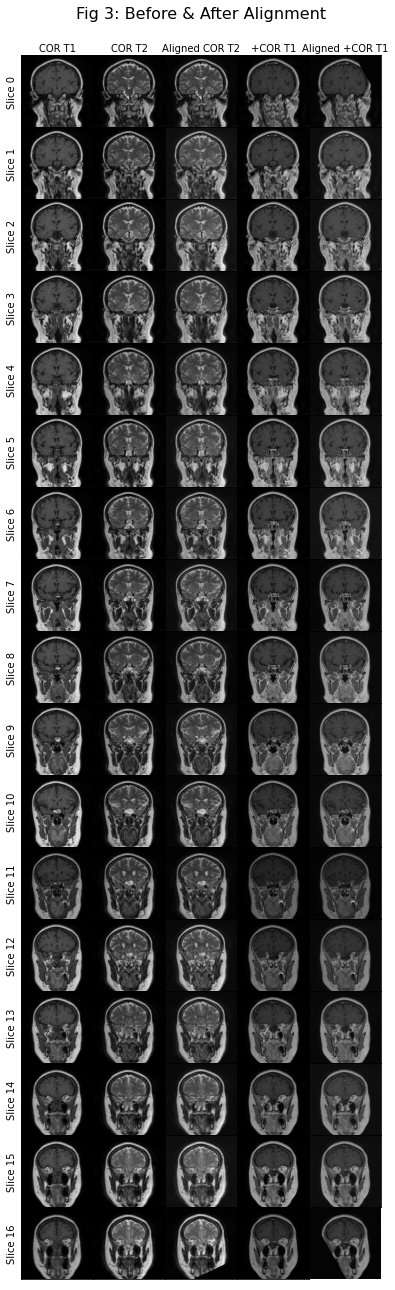

In [30]:
ncols = len(col_ims)
nrows = nslices

# fig options
fig_mult = 1
options = {
    "wspace": 0.0,
    "hspace": 0.0,
}

fig = plt.figure(figsize=(fig_mult*(ncols+1), fig_mult*(nrows+1))) 
gs  = gridspec.GridSpec(nrows, ncols,
        wspace=options["wspace"], hspace=options["hspace"], 
        top=1.-0.5/(nrows+1), bottom=0.5/(nrows+1), 
        left=0.5/(ncols+1), right=1-0.5/(ncols+1)) 
    
for row_idx, slice_idx in enumerate(range(nslices)):
    for col_idx, im_arr in enumerate(col_ims):
        im = np.take(im_arr, slice_idx, axis=axis)
        
        # plot original slice
        ax = plt.subplot(gs[row_idx,col_idx])
        ax.imshow(np.rot90(im), cmap=plt.cm.gray)
        
        # label the columns top of the plot
        if row_idx == 0:
            ax.set_xlabel(f'{col_names[col_idx]}')    
            ax.xaxis.set_label_position('top') 
       
        if col_idx == 0:
            # label the rows on the left side of the plot
            ax.set_ylabel(f'Slice {row_idx}')    
            ax.yaxis.set_label_position('left') 
            
        # remove tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax_next.set_xticks([])
        ax_next.set_yticks([])

fig.suptitle('Fig 3: Before & After Alignment', y=1.01, fontsize=16)
plt.axis('off')

In [ ]:
# im_arr = ims[0]
# interact(explore_3dimage, 
#          layer0=(0, im_arr.shape[0] - 1), 
#          layer1=(0, im_arr.shape[1] - 1), 
#          layer2=(0, im_arr.shape[2] - 1),
#          im_arr=fixed(im_arr));